
<font color='gray'>

## Data Science Challenge

The purpose of this challenge is to assist us in evaluating candidates for a role in our Product team. We only pass this challenge to candidates that we feel have a solid background and could be a good fit for our team. We appreciate you taking this time to help ensure we’re a good fit for each other.

### Tips
- Include code, graphics and text in a combined output. Tell a story, and let us know very clearly about your thoughts and analytical process.

### Part 1: Experiment design
#### Background
In 2011 AirBnB ran some experiments which showed that when a property featured professional photography, users were much more likely to trust the property and consequently make a booking. So, AirBnB a launched [free professional photography service](https://www.airbnb.com/professional_photography) for all hosts. From inside the listing page, hosts were able to click a link to view more about the service, request a professional photographer, and subsequently (after the photo shoot) have their property profile updated with professional photos. 

The project initially proved to be a success:
- Guests were more likely to book a property that had professional photography.
- Hosts were able to charge more for listings with professional photos.

However, over time this also became a multimillion dollar operation and a challenge to manage across over 200 countries. 

Fast forward to 2016, and some new developments have also helped with building trust:

- 2013: Launch of identity verification for hosts and guests.
- 2014: Launch of double blind reviews (neither host nor guest can see the other’s review), ensuring more honest reviews of properties and hosts. 
- 2015: Huge global PR lift for AirBnB, raising the profile of the company.

An additional interesting development has also been the proliferation of smartphones with powerful and high-quality cameras (+apps) over the last few years, which has made it more possible for hosts to take good quality photos of their property. There is also the opinion that perhaps millennials have come to expect smartphone photos as the norm and are less likely to expect professional photography. 

#### Challenge

Since the professional photography service consumes so many operational and financial resources, AirBnB management are unsure if they should continue. AirBnB management have asked the Data Science team to analyse the impact of the professional photography service in order to determine whether or not they should continue funding the service. 

- Provide full details about how you will run experiments to assess the impact of this service on both hosts and guests. How will you ensure that the experiments are valid and not biased? 

</font>



---------------------------------------------

## Response to the Part 1


I will do a A/B testing and using different metrics to assess the impact of the professional photos.

**Benchmark**

Average price per night without using professional photos

**Metrics**  
1. Does the professional photo make more click rate?
2. Does the professional photo make more conversion rate?
3. Does the professional photo lead a higher profit or not? (optional)

**Period**  

30 days (based on this [ref](https://medium.com/airbnb-engineering/experiments-at-airbnb-e2db3abf39e7))

**Sample groups**  

The sample size depends on the control conversion rate/click rate. Let's set the splitting size 50% vs. 50%.   
I'd choose 5 tops cities where there are more demanding on AirBnb and randomly choose control vs. test flats by area and price. 


**Steps**  
Using Bacelona as an example.  
1. I may choose in total 50 flats in L'Eixample with similar nightly price. 
2. Split them into 25 flats for control and 25 flats for test and run the test for 30 days but excluding the holiday in order to prevent the bias. 
3. Switch these two groups and run for the other 30 days to see if there is any impact from the professional photos.
4. Other than switch the two groups, we can also test with different price of flats. (I am not sure of this part)
5. Calulating p-values of the click rate and conversion rate between groups along the 30 days.







-----------------------------

<font color='gray'>
    
### Part 2: Result analysis

#### Background
A ride hailing app currently assigns new incoming trips to the _closest_ available vehicle. To compute such distance, the app currently computes haversine distance between the pickup point and each of the available vehicles. We refer to this distance as *linear*. 

However, the expected time to reach A from B in a city is not 100% defined by Haversine distance:
cities are known to be places where huge amount of transport infrastructure (roads, highways, bridges, tunnels) is deployed to increase capacity and reduce average travel time. Interestingly, this heavy investment in infrastructure also implies that bird distance does not work so well as proxy, so the isochrones for travel time from certain location drastically differ from the perfect circle defined by bird distance, as we can see in this example from CDMX where the blue area represents that it is reachable within a 10 min drive. 

![Imgur](https://i.imgur.com/hYXhpiM.png)
 
In addition to this, travel times can be drastically affected by traffic, accidents, road work...So that even if a driver is only 300m away, he might need to drive for 10 min because of road work in a bridge.

#### Proposal
In order to optimise operations, engineering team has suggested they could query an external real time maps API that not only has roads, but also knows realtime traffic information. We refer to this distance as *road* distance.

In principle this assignment is more efficient and should outperform *linear*. However, the queries to the maps API have a certain cost (per query) and increase the complexity and reliability of a critical system within the company. So Data Science team has designed an experiment to help engineering to decide.

#### Experimental design

The designed experiment is very simple. For a period of 5 days, all trips in 3 cities (Bravos, Pentos and Volantis) have been randomly assigned using *linear* or *road* distance:

* Trips whose *trip_id* starts with digits 0-8 were assigned using *road* distance.
* Trips whose *trip_id* starts with digits 9-f were assigned using *linear* distance.

#### Data description
The collected data is available in [this link](https://www.dropbox.com/s/e3j1pybfz5o3vq9/intervals_challenge.json.gz?dl=0). Each object represent a `vehicle_interval` that contains the following attributes:

* `type`: can be `going_to_pickup`, `waiting_for_rider` or `driving_to_destination`. 
* `trip_id`: uniquely identifies the trip.
* `duration`: how long the interval last, in seconds.
* `distance`: how far the vehicle moved in this interval, in meters.
* `city_id`: either bravos, pentos and volantis.
* `started_at`: when the interval started, UTC Time.
* `vehicle_id`: uniquely identifies the vehicle.
* `rider_id`: uniquely identifies the rider.

#### Example
```
{
  "duration": 857,
  "distance": 5384,
  "started_at": 1475499600.287,
  "trip_id": "c00cee6963e0dc66e50e271239426914",
  "vehicle_id": "52d38cf1a3240d5cbdcf730f2d9a47d6",
  "city_id": "pentos",
  "type": "driving_to_destination"
}
```

#### Challenge
Try to answer the following questions:

1. Should the company move towards *road* distance? What's the max price it would make sense to pay per query? (make all the  assumptions you need, and make them explicit)
2. How would you improve the experimental design? Would you collect any additional data? 

</font>

-------------

## Response to the Part 2





In [137]:
import pandas as pd
import numpy as np
import json
from scipy import stats
import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
%matplotlib inline
import re
import warnings
warnings.filterwarnings("ignore")

In [44]:
import pandas as pd
df = pd.read_json ('data/intervals_challenge.json', lines=True)

In [45]:
df.head()

,duration,distance,started_at,trip_id,vehicle_id,city_id,type
0,857,5384,2016-10-03 13:00:00.286999941,c00cee6963e0dc66e50e271239426914,52d38cf1a3240d5cbdcf730f2d9a47d6,pentos,driving_to_destination
1,245,1248,2016-10-03 13:00:00.852999926,427425e1f4318ca2461168bdd6e4fcbd,8336b28f24c3e7a1e3d582073b164895,volantis,going_to_pickup
2,1249,5847,2016-10-03 13:00:01.670000076,757867f6d7c00ef92a65bfaa3895943f,8885c59374cc539163e83f01ed59fd16,pentos,driving_to_destination
3,471,2585,2016-10-03 13:00:01.841000080,d09d1301d361f7359d0d936557d10f89,81b63920454f70b6755a494e3b28b3a7,bravos,going_to_pickup
4,182,743,2016-10-03 13:00:01.970000029,00f20a701f0ec2519353ef3ffaf75068,b73030977cbad61c9db55418909864fa,pentos,going_to_pickup


In [46]:
df.describe()

,duration,distance,started_at,trip_id,vehicle_id,city_id,type
count,165170.0,165170.0,165170,165170,165170,165170,165170
unique,3344.0,13185.0,165012,58686,4746,3,3
top,4.0,0.0,2016-10-03 13:00:52.447000027,afacd04e18402f482e950ecc17c9f998,6661ee4bee90709e97c50a6bcb5ac682,pentos,going_to_pickup
freq,2972.0,16470.0,2,10,150,113684,58510
first,NaN,NaN,2016-10-03 13:00:00.286999941,NaN,NaN,NaN,NaN
last,NaN,NaN,2016-10-04 20:36:20.473999977,NaN,NaN,NaN,NaN


In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165170 entries, 0 to 165169
Data columns (total 7 columns):
duration      165170 non-null object
distance      165170 non-null object
started_at    165170 non-null datetime64[ns]
trip_id       165170 non-null object
vehicle_id    165170 non-null object
city_id       165170 non-null object
type          165170 non-null object
dtypes: datetime64[ns](1), object(6)
memory usage: 8.8+ MB


### Identify the linear or road distance type

As we are going to compare if these two types have any different, we need to identify them first

In [48]:
# Define a function to separate the distance type by the first letter/number

def regex_filter(val):
    mo = re.search(r'^[0-8]',val)
    if mo:
        return "road"
    else:
        return "linear"

df["distance_type"] = df["trip_id"].apply(regex_filter)

In [49]:
df.head()

,duration,distance,started_at,trip_id,vehicle_id,city_id,type,distance_type
0,857,5384,2016-10-03 13:00:00.286999941,c00cee6963e0dc66e50e271239426914,52d38cf1a3240d5cbdcf730f2d9a47d6,pentos,driving_to_destination,linear
1,245,1248,2016-10-03 13:00:00.852999926,427425e1f4318ca2461168bdd6e4fcbd,8336b28f24c3e7a1e3d582073b164895,volantis,going_to_pickup,road
2,1249,5847,2016-10-03 13:00:01.670000076,757867f6d7c00ef92a65bfaa3895943f,8885c59374cc539163e83f01ed59fd16,pentos,driving_to_destination,road
3,471,2585,2016-10-03 13:00:01.841000080,d09d1301d361f7359d0d936557d10f89,81b63920454f70b6755a494e3b28b3a7,bravos,going_to_pickup,linear
4,182,743,2016-10-03 13:00:01.970000029,00f20a701f0ec2519353ef3ffaf75068,b73030977cbad61c9db55418909864fa,pentos,going_to_pickup,road


In [50]:
# Have a look of their distribution

df["distance_type"].value_counts()

road      93652
linear    71518
Name: distance_type, dtype: int64

### Extract only the "going to pickup"
As the main question is about to study the difference of distance type between the pickup point and each of the available vehicles, I will first focus on only the type of "going to pickup"

In [51]:
# As usual, have a look of the number of each type

df["type"].value_counts()

going_to_pickup           58510
waiting_for_rider         53746
driving_to_destination    52914
Name: type, dtype: int64

In [52]:
# Choose only the going to pickup type

df_pickup = df[df["type"] == "going_to_pickup"]

In [53]:
df_pickup.describe()

,duration,distance,started_at,trip_id,vehicle_id,city_id,type,distance_type
count,58510,58510.0,58510,58510,58510,58510,58510,58510
unique,1851,4218.0,58488,58468,4745,3,1,2
top,NA,0.0,2016-10-03 23:23:35.987999916,afacd04e18402f482e950ecc17c9f998,a3e0ec5c6ea97b306dbe4fcabd47f2b5,pentos,going_to_pickup,road
freq,299,1421.0,2,9,58,40064,58510,33171
first,NaN,NaN,2016-10-03 13:00:00.852999926,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,2016-10-04 20:36:20.473999977,NaN,NaN,NaN,NaN,NaN


It seems that the duration and distance columns have some string and their data types are not integer. I will change them here.

In [54]:
df_pickup["duration"] = np.where(df_pickup["duration"] == "NA", 0, df_pickup["duration"])
df_pickup["distance"] = np.where(df_pickup["distance"] == "NA", 0, df_pickup["distance"])

In [55]:
df_pickup["distance"] = df_pickup["distance"].astype("int")
df_pickup["duration"] = df_pickup["duration"].astype("int")

In [56]:
# Check if they are all as integer and also the description

df_pickup.describe()

,duration,distance
count,58510.000000,5.851000e+04
mean,298.632559,9.794360e+02
std,291.058871,1.043448e+04
min,0.000000,0.000000e+00
25%,140.000000,3.040000e+02
50%,236.000000,6.280000e+02
75%,370.000000,1.067000e+03
max,9441.000000,1.218089e+06


In [57]:
# There are some cells with 0, in order to avoid the possible error cause by 0, 
# I create a df with no 0 in the duration and distance column

df_pickup_no_zero = df_pickup.loc[(df_pickup["duration"] != 0) & (df_pickup["distance"] != 0)]

In [58]:
df_pickup_no_zero.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56778 entries, 1 to 165111
Data columns (total 8 columns):
duration         56778 non-null int64
distance         56778 non-null int64
started_at       56778 non-null datetime64[ns]
trip_id          56778 non-null object
vehicle_id       56778 non-null object
city_id          56778 non-null object
type             56778 non-null object
distance_type    56778 non-null object
dtypes: datetime64[ns](1), int64(2), object(5)
memory usage: 3.9+ MB


In [59]:
# As there are some 0, I replace them as np.nan

df_pickup_no_zero["speed"] = (df_pickup_no_zero["distance"]/df_pickup_no_zero["duration"]).replace(np.inf, np.nan)

In [60]:
df_pickup_no_zero.head()

,duration,distance,started_at,trip_id,vehicle_id,city_id,type,distance_type,speed
1,245,1248,2016-10-03 13:00:00.852999926,427425e1f4318ca2461168bdd6e4fcbd,8336b28f24c3e7a1e3d582073b164895,volantis,going_to_pickup,road,5.093878
3,471,2585,2016-10-03 13:00:01.841000080,d09d1301d361f7359d0d936557d10f89,81b63920454f70b6755a494e3b28b3a7,bravos,going_to_pickup,linear,5.488323
4,182,743,2016-10-03 13:00:01.970000029,00f20a701f0ec2519353ef3ffaf75068,b73030977cbad61c9db55418909864fa,pentos,going_to_pickup,road,4.082418
5,599,1351,2016-10-03 13:00:02.154000044,158e7bc8d42e1d8c94767b00c8f89568,126e868fb282852c2fa95d88878686bf,volantis,going_to_pickup,road,2.255426
9,1525,2674,2016-10-03 13:00:05.637000084,d3e6e8fb50c02d66feca2c60830c4fcc,b0906e917dc5cc0bcba190fd80079a74,bravos,going_to_pickup,linear,1.753443


### Test with data without clean the outlier

In [86]:
df_pickup_no_zero.groupby(["city_id", "distance_type"]).agg(avg_duration = ("duration", "mean"),
                                                            std_duration = ("duration", np.std),
                                                            avg_distance = ("distance", "mean"),
                                                            std_distance = ("distance", np.std),
                                                            avg_speed = ("speed", "mean"),
                                                            std_speed = ("speed", np.std))

avg_duration  std_duration  avg_distance  \
city_id  distance_type                                             
bravos   linear           586.286722    466.236844   3180.914523   
         road             610.236369    527.761864   3217.240151   
pentos   linear           257.982051    202.439127    715.782793   
         road             257.246824    192.097108    743.383031   
volantis linear           334.159314    334.964468    894.552495   
         road             325.768756    324.920900    894.336394   

                        std_distance   avg_speed     std_speed  
city_id  distance_type                                          
bravos   linear         29371.779010  403.336240  18166.192726  
         road           35853.712841  108.180565   3927.682326  
pentos   linear           694.151164    4.186768     37.457206  
         road            2641.254816    4.550042     45.970079  
volantis linear          1103.890050    5.636464     47.644139  
         road            1445.740442    5.410227     48.385069

By looking at the average speed it seems that there is a difference between the distance type, but the standard deviation is pretty high. Os I think it would be better to clean the outlier

### Test with data without outlier (data with z score lower than 2)

In [61]:
# There are some values way too high, I treat them as outlier (z score > 3) and will not use them in the analysis

#df_clean = df_pickup_no_zero[(np.abs(stats.zscore(df_pickup_no_zero))<3).all(axis=1)]

df_pickup_no_zero["duration_z"] = np.abs(stats.zscore(df_pickup_no_zero["duration"]))
df_pickup_no_zero["distance_z"] = np.abs(stats.zscore(df_pickup_no_zero["distance"]))


In [63]:
df_pickup_no_zero.describe()

,duration,distance,speed,duration_z,distance_z
count,56778.000000,5.677800e+04,56778.000000,56778.000000,56778.000000
mean,306.604583,1.009190e+03,27.364464,0.600118,0.072133
std,291.255381,1.059102e+04,3856.486374,0.799919,0.997404
min,1.000000,1.000000e+00,0.000257,0.001358,0.000018
25%,147.000000,3.330000e+02,1.756375,0.228683,0.025003
50%,241.000000,6.500000e+02,2.612635,0.458006,0.049778
75%,376.000000,1.086000e+03,3.658287,0.716232,0.074516
max,9441.000000,1.218089e+06,890705.000000,31.362428,114.917173


In [116]:
df_clean = df_pickup_no_zero[(df_pickup_no_zero["duration_z"] < 2) & (df_pickup_no_zero["distance_z"] < 2)]

In [117]:
df_clean.describe()

,duration,distance,speed,duration_z,distance_z
count,54959.000000,54959.000000,54959.000000,54959.000000,54959.000000
mean,268.747266,796.315180,5.269636,0.489744,0.054146
std,170.772273,796.129588,46.537663,0.347610,0.055882
min,1.000000,1.000000,0.001908,0.001358,0.000018
25%,144.000000,323.000000,1.774805,0.221816,0.024473
50%,235.000000,629.000000,2.626168,0.441557,0.048797
75%,358.000000,1038.000000,3.673619,0.688046,0.072911
max,889.000000,21705.000000,3349.000000,1.999622,1.954107


In [118]:
df_clean = df_clean.drop(columns = ["duration_z", "distance_z"])

Now the data should be basically clean, let's have a look of the descriptive result

In [119]:
df_clean.groupby(["city_id", "distance_type"]).agg(avg_duration = ("duration", "mean"),
                                                   std_duration = ("duration", np.std),
                                                   avg_distance = ("distance", "mean"),
                                                   std_distance = ("distance", np.std),
                                                   avg_speed = ("speed", "mean"),
                                                   std_speed = ("speed", np.std))

avg_duration  std_duration  avg_distance  \
city_id  distance_type                                             
bravos   linear           416.589692    222.105836   1569.552804   
         road             413.614076    222.069279   1584.935808   
pentos   linear           247.279287    151.301983    694.539970   
         road             247.350424    152.720355    703.899885   
volantis linear           286.291192    178.615643    822.330937   
         road             279.603236    174.972394    800.688140   

                        std_distance  avg_speed  std_speed  
city_id  distance_type                                      
bravos   linear          1338.377375  13.078349  96.559090  
         road            1349.507758  12.381194  81.009602  
pentos   linear           585.265111   4.207843  37.642811  
         road             627.676510   4.344857  37.929794  
volantis linear           895.746395   5.773342  48.504985  
         road             865.806918   5.519300  49.212527

We can see that there is a difference between the average speed between distance type, but it needs a statistic examination

#### t test for speed between distance type

In [120]:
# Select only speed to see if their t values are significant different or not

bravos_linear_speed = df_clean[(df_clean["city_id"] == "bravos") & (df_clean["distance_type"] == "linear")]["speed"]
bravos_road_speed = df_clean[(df_clean["city_id"] == "bravos") & (df_clean["distance_type"] == "road")]["speed"]
pentos_linear_speed = df_clean[(df_clean["city_id"] == "pentos") & (df_clean["distance_type"] == "linear")]["speed"]
pentos_road_speed = df_clean[(df_clean["city_id"] == "pentos") & (df_clean["distance_type"] == "road")]["speed"]
volantis_linear_speed = df_clean[(df_clean["city_id"] == "volantis") & (df_clean["distance_type"] == "linear")]["speed"]
volantis_road_speed = df_clean[(df_clean["city_id"] == "volantis") & (df_clean["distance_type"] == "road")]["speed"]

In [121]:
# t test of speed between linear distance type and road distance type in Bravos
stats.ttest_ind(bravos_linear_speed, bravos_road_speed)

Ttest_indResult(statistic=0.2649905909735789, pvalue=0.7910286795175048)

In [122]:
# t test of speed between linear distance type and road distance type in Pentos
stats.ttest_ind(pentos_linear_speed, pentos_road_speed)

Ttest_indResult(statistic=-0.35326078691397506, pvalue=0.7238948669964911)

In [123]:
# t test of speed between linear distance type and road distance type in Volantis
stats.ttest_ind(volantis_linear_speed, volantis_road_speed)

Ttest_indResult(statistic=0.27835752317486273, pvalue=0.7807428244306753)

#### t test for duration between distance type

In [124]:
# Select only duration to see if their t values are significant different or not

bravos_linear_duration = df_clean[(df_clean["city_id"] == "bravos") & (df_clean["distance_type"] == "linear")]["duration"]
bravos_road_duration = df_clean[(df_clean["city_id"] == "bravos") & (df_clean["distance_type"] == "road")]["duration"]
pentos_linear_duration = df_clean[(df_clean["city_id"] == "pentos") & (df_clean["distance_type"] == "linear")]["duration"]
pentos_road_duration = df_clean[(df_clean["city_id"] == "pentos") & (df_clean["distance_type"] == "road")]["duration"]
volantis_linear_duration = df_clean[(df_clean["city_id"] == "volantis") & (df_clean["distance_type"] == "linear")]["duration"]
volantis_road_duration = df_clean[(df_clean["city_id"] == "volantis") & (df_clean["distance_type"] == "road")]["duration"]


In [125]:
# t test of duration between linear distance type and road distance type in Bravos
stats.ttest_ind(bravos_linear_duration, bravos_road_duration)

Ttest_indResult(statistic=0.4486153947690732, pvalue=0.6537304285180139)

In [126]:
# t test of duration between linear distance type and road distance type in Pentos
stats.ttest_ind(pentos_linear_duration, pentos_road_duration)

Ttest_indResult(statistic=-0.04558621947898559, pvalue=0.9636402885407571)

In [127]:
# t test of duration between linear distance type and road distance type in Volantis
stats.ttest_ind(volantis_linear_duration, volantis_road_duration)

Ttest_indResult(statistic=2.030378910328929, pvalue=0.04234053110448333)

#### t test for distance between distance type

In [128]:
# Select only distance to see if their t values are significant different or not

bravos_linear_distance = df_clean[(df_clean["city_id"] == "bravos") & (df_clean["distance_type"] == "linear")]["distance"]
bravos_road_distance = df_clean[(df_clean["city_id"] == "bravos") & (df_clean["distance_type"] == "road")]["distance"]
pentos_linear_distance = df_clean[(df_clean["city_id"] == "pentos") & (df_clean["distance_type"] == "linear")]["distance"]
pentos_road_distance = df_clean[(df_clean["city_id"] == "pentos") & (df_clean["distance_type"] == "road")]["distance"]
volantis_linear_distance = df_clean[(df_clean["city_id"] == "volantis") & (df_clean["distance_type"] == "linear")]["distance"]
volantis_road_distance = df_clean[(df_clean["city_id"] == "volantis") & (df_clean["distance_type"] == "road")]["distance"]


In [129]:
# t test of distance between linear distance type and road distance type in Bravos
stats.ttest_ind(bravos_linear_distance, bravos_road_distance)

Ttest_indResult(statistic=-0.3830314033307804, pvalue=0.7017143220875572)

In [130]:
# t test of distance between linear distance type and road distance type in Pentos
stats.ttest_ind(pentos_linear_distance, pentos_road_distance)

Ttest_indResult(statistic=-1.4966602718476627, pvalue=0.13448984459381275)

In [131]:
# t test of distance between linear distance type and road distance type in Volantis
stats.ttest_ind(volantis_linear_distance, volantis_road_distance)

Ttest_indResult(statistic=1.3200453374983592, pvalue=0.18684561402283278)

## Looking at the peak and off-peak hour impacts

In [132]:
df_clean.head()

,duration,distance,started_at,trip_id,vehicle_id,city_id,type,distance_type,speed
1,245,1248,2016-10-03 13:00:00.852999926,427425e1f4318ca2461168bdd6e4fcbd,8336b28f24c3e7a1e3d582073b164895,volantis,going_to_pickup,road,5.093878
3,471,2585,2016-10-03 13:00:01.841000080,d09d1301d361f7359d0d936557d10f89,81b63920454f70b6755a494e3b28b3a7,bravos,going_to_pickup,linear,5.488323
4,182,743,2016-10-03 13:00:01.970000029,00f20a701f0ec2519353ef3ffaf75068,b73030977cbad61c9db55418909864fa,pentos,going_to_pickup,road,4.082418
5,599,1351,2016-10-03 13:00:02.154000044,158e7bc8d42e1d8c94767b00c8f89568,126e868fb282852c2fa95d88878686bf,volantis,going_to_pickup,road,2.255426
11,291,683,2016-10-03 13:00:06.209000111,a1ea9187c75d05ad0be0856e581298f0,d515623145835dc3cc0f850f22abeff8,pentos,going_to_pickup,linear,2.347079


In [133]:
df_clean["hour"] = df_clean["started_at"].dt.hour

In [134]:
df_clean.head()

,duration,distance,started_at,trip_id,vehicle_id,city_id,type,distance_type,speed,hour
1,245,1248,2016-10-03 13:00:00.852999926,427425e1f4318ca2461168bdd6e4fcbd,8336b28f24c3e7a1e3d582073b164895,volantis,going_to_pickup,road,5.093878,13
3,471,2585,2016-10-03 13:00:01.841000080,d09d1301d361f7359d0d936557d10f89,81b63920454f70b6755a494e3b28b3a7,bravos,going_to_pickup,linear,5.488323,13
4,182,743,2016-10-03 13:00:01.970000029,00f20a701f0ec2519353ef3ffaf75068,b73030977cbad61c9db55418909864fa,pentos,going_to_pickup,road,4.082418,13
5,599,1351,2016-10-03 13:00:02.154000044,158e7bc8d42e1d8c94767b00c8f89568,126e868fb282852c2fa95d88878686bf,volantis,going_to_pickup,road,2.255426,13
11,291,683,2016-10-03 13:00:06.209000111,a1ea9187c75d05ad0be0856e581298f0,d515623145835dc3cc0f850f22abeff8,pentos,going_to_pickup,linear,2.347079,13


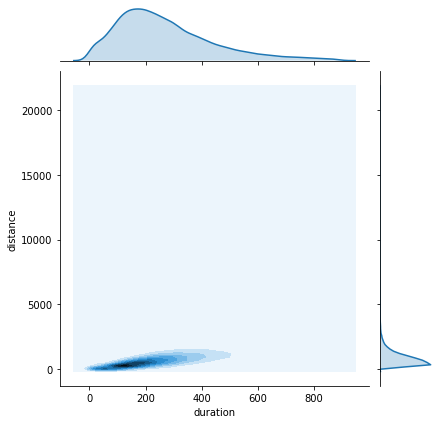

In [135]:
sns.jointplot(x="duration", y="distance", data=df_clean, kind="kde")

In [147]:
bravos = df_clean[(df_clean["city_id"] == "bravos")]
pentos = df_clean[(df_clean["city_id"] == "pentos")]
volantis = df_clean[(df_clean["city_id"] == "volantis") ]


Text(0.5, 1.0, 'Distance types in Bravos')

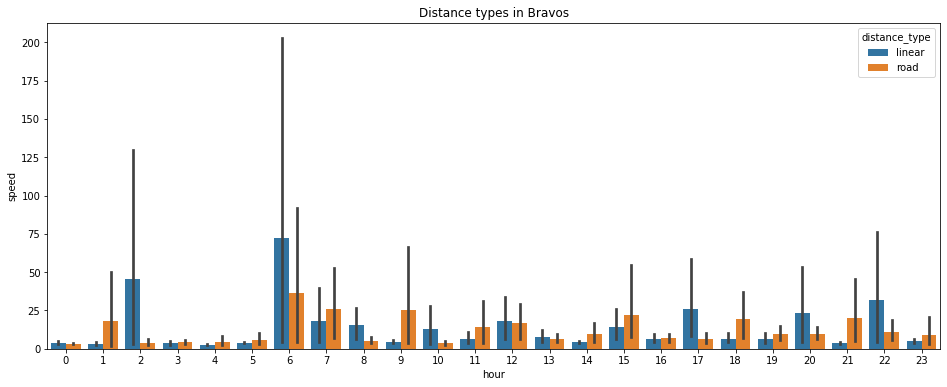

In [161]:
plt.figure(figsize=(16, 6))
sns.barplot(bravos["hour"], bravos["speed"], hue = bravos["distance_type"]).set_title("Distance types in Bravos")

Text(0.5, 1.0, 'Distance types in Pentos')

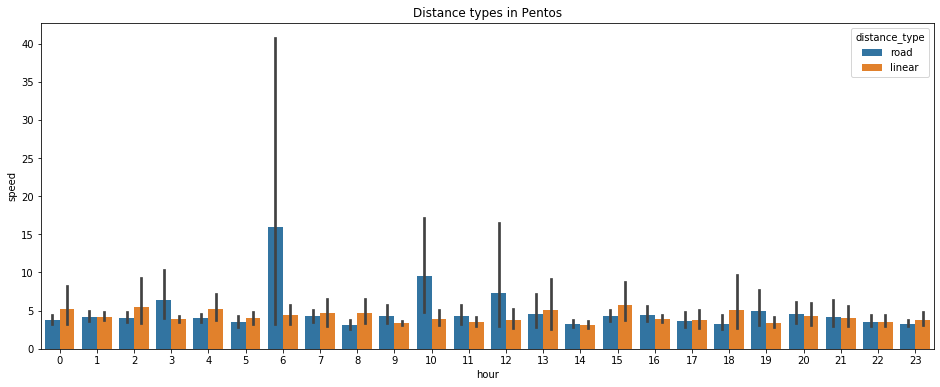

In [160]:
plt.figure(figsize=(16, 6))
sns.barplot(pentos["hour"], pentos["speed"], hue = pentos["distance_type"]).set_title("Distance types in Pentos")

Text(0.5, 1.0, 'Distance types in Volantis')

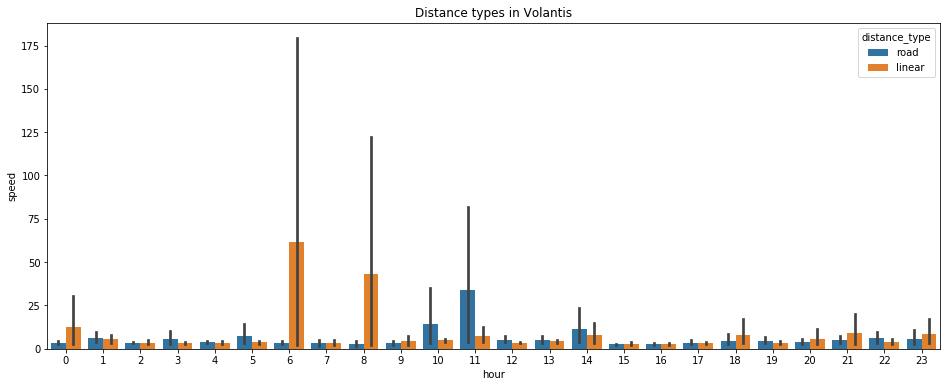

In [159]:
plt.figure(figsize=(16, 6))
sns.barplot(volantis["hour"], volantis["speed"], hue = volantis["distance_type"]).set_title("Distance types in Volantis")

---

## Response to the questions

**Question 1**   
Should the company move towards road distance? What's the max price it would make sense to pay per query? (make all the assumptions you need, and make them explicit)




**Response**  
By looking at the t test between distance type in each city, it seems that there is no statistic difference between the distance type. Therefore I won't suggest to use real-time query.

If I'd have time, I will also look at the distance type at different hours (for example peak hour and off-peak hour). Now I only have time to visualize it, and from the figure one can see that there are some hours stand quite different to the others, meaning that this may bring bias to our analysis. Moreover, I didn't have time to do the normalization, I think it is very important.


**Question 2**  
How would you improve the experimental design? Would you collect any additional data?

**Response**  
I'd add the coordinate where the passenger wait and where the car is waiting. It is to caluclate the true linear distance and see the difference between the geographic distance and driving distance.
